# Read the data

## Installing PySpark

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder.appName("AmazonReviewSampling").getOrCreate()

^C


ModuleNotFoundError: No module named 'pyspark'


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\ramin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/317.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.2 MB ? eta -:--:--
     -------------------------------------- 0.0/317.2 MB 217.9 kB/s eta 0:24:16
     -------------------------------------- 0.0/317.2 MB 245.8 kB/s eta 0:21:31
     -------------------------------------- 0.2/317.2 MB 706.2 kB/s eta 0:07:29
     ---------------------------------------- 0.3/317.2 MB 1.3 MB/s eta 0:04:10
     ---------------------------------------- 0.7/317.2 MB 2.2 MB/s eta 0:02:22
     ---------------------------------------- 1.3/317.2 MB 3.7 MB/s eta 0:01:27
     ---------------------------------------- 1.8/317.2 MB 4.5 MB/s eta 0:01:11
     ---------------------------------------- 2.3/317.2 MB 5.2 MB/s eta 0:01:01
     ---------------------------------------- 2.8/317.2 MB 5.8 MB/s eta 0:00:55
     ---------------------------------------- 3.5/317.2 MB 6.

## Read the data in Spark format

In [2]:
# For CSV file
df = spark.read.csv('/kaggle/input/amazon-customerreviews-polarity/train.csv', header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- 2: integer (nullable = true)
 |-- Stuning even for the non-gamer: string (nullable = true)
 |-- This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^: string (nullable = true)

+---+------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  2|Stuning even for the non-gamer|This

## Sample the data

In [3]:
# Sample ~10% of the dataset (adjust fraction as needed)
sampled_df = df.sample(fraction=0.1, seed=42)
print(f"Original rows: {df.count()} | Sampled rows: {sampled_df.count()}")

Original rows: 3599999 | Sampled rows: 359709


## Convert to Pandas and Save for Later

In [4]:
# Convert sampled Spark DataFrame to Pandas
sampled_pd = sampled_df.toPandas()

# Save sampled file to disk
sampled_pd.to_csv("sampled_amazon_reviews.csv", index=False)

## Load and Inspect the Sampled Data

In [1]:
import pandas as pd

# Load sampled CSV
df = pd.read_csv("sampled_amazon_reviews.csv")

# Preview
print(df.head())
print(df.columns)

   2                   Stuning even for the non-gamer  \
0  2                                 A FIVE STAR BOOK   
1  2               Fashionable Compression Stockings!   
2  1  sizes recomended in the size chart are not real   
3  2                               Nice for the money   
4  1                                    Disappointing   

  This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^  
0  I just finished reading Whisper of the Wicked ...                                                                                                                                                                                                              

# preprocessing

## Set custom column names

In [2]:
df = pd.read_csv("C:/Users/ramin/Downloads/sampled_amazon_reviews.csv", header=None, names=["label", "title", "content"])

In [3]:
df.head(5)

,label,title,content
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
2,2,Fashionable Compression Stockings!,After I had a DVT my doctor required me to wea...
3,1,sizes recomended in the size chart are not real,sizes are much smaller than what is recomended...
4,2,Nice for the money,The first one I bought was defective. The DVD ...


## Remap labels

## Lowercasing, Punctuation removal, Stopword removal, Tokenization

In [6]:
import os, nltk

# 1) Build & point to your nltk_data folder
nltk_data_dir = os.path.join(os.getenv("APPDATA"), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# 2) Make NLTK use it *first*
os.environ["NLTK_DATA"] = nltk_data_dir
nltk.data.path.insert(0, nltk_data_dir)

# 3) Download the resources you’ll need
nltk.download("punkt",              download_dir=nltk_data_dir)
nltk.download("stopwords",          download_dir=nltk_data_dir)
nltk.download("averaged_perceptron_tagger", download_dir=nltk_data_dir)

# 4) Sanity-check: these should print full paths under your AppData folder
print("Punkt:",     nltk.data.find("tokenizers/punkt/english.pickle"))
print("Stopwords:", nltk.data.find("corpora/stopwords.zip"))



Punkt: C:\Users\ramin\AppData\Roaming\nltk_data\tokenizers\punkt\english.pickle
Stopwords: C:\Users\ramin\AppData\Roaming\nltk_data\corpora\stopwords.zip


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
import re
import string
from nltk.corpus import stopwords

# 1) Load stopwords (you already have them downloaded)
stop_words = set(stopwords.words("english"))

# 2) Define a regex‐based “tokenizer” + cleaner
token_pattern = re.compile(r"\b[a-zA-Z]+\b")

def clean_text(text):
    text = str(text).lower().replace("\n", " ")
    # strip punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # find all alpha‐only “words”
    tokens = token_pattern.findall(text)
    # filter out stopwords
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# 3) Apply it
df["text"] = (
    df["title"].fillna("") + " " + df["content"].fillna("")
).apply(clean_text)

df = df[["text", "label"]]

# 4) Quick peek
print(df.head())




                                                text  label
0  stuning even nongamer sound track beautiful pa...      2
1  five star book finished reading whisper wicked...      2
2  fashionable compression stockings dvt doctor r...      2
3  sizes recomended size chart real sizes much sm...      1
4  nice money first one bought defective dvd didn...      2


## Check the cleaned text and labels

In [9]:
print(df.head(20))

                                                 text  label
0   stuning even nongamer sound track beautiful pa...      2
1   five star book finished reading whisper wicked...      2
2   fashionable compression stockings dvt doctor r...      2
3   sizes recomended size chart real sizes much sm...      1
4   nice money first one bought defective dvd didn...      2
5   disappointing text ever think plates markedly ...      1
6   didnt live expectations ordered shoes replace ...      1
7   even mommy fun one four year old daughter love...      2
8   use imagination year old daughter love softwar...      2
9   audio options non existent movie better expect...      1
10  ariel litte mermaid pearl kit arrived quickly ...      1
11  soulwax ignored critics consumers alike dont g...      2
12  addonics portable cd drive disappointed perfor...      1
13  authentic first encounter yoruba say cds reall...      2
14  best agree cds much needed help since would im...      1
15  kelly club pet parad

# EDA

## Check Class Distribution (Imbalance Check)

In [10]:
print(df['label'].value_counts())

label
2    180108
1    179602
Name: count, dtype: int64


## Word Cloud (visualize common words in positive reviews)

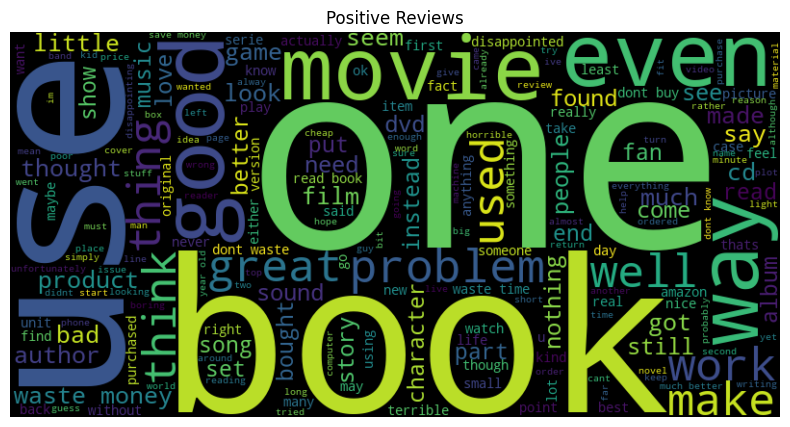

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word cloud for positive reviews
pos_text = ' '.join(df[df['label'] == 1]['text'].tolist())
wordcloud = WordCloud(width=800, height=400).generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews")
plt.show()

## word cloud (visualize common words in negative reviews)

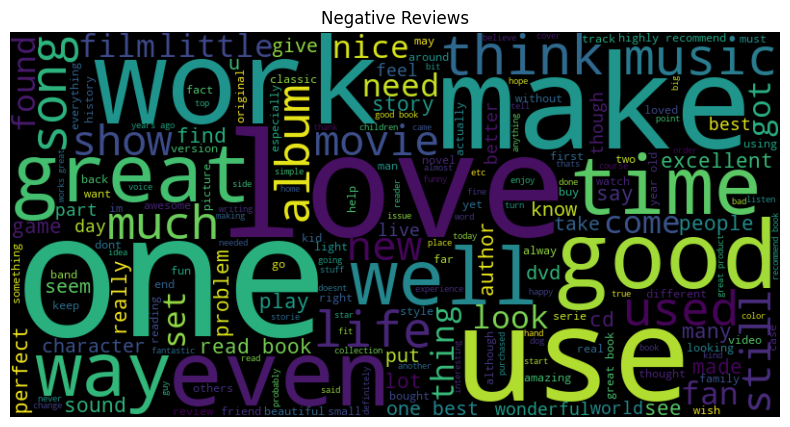

In [14]:
# Word cloud for negative reviews
pos_text = ' '.join(df[df['label'] == 2]['text'].tolist())
wordcloud = WordCloud(width=800, height=400).generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews")
plt.show()

# Classification Models

 ## Naive Bayes Classification

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Feature extraction (Bag of Words)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Predict
y_pred = nb.predict(X_test_vec)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8443746351227378
Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.85      0.85     36008
           2       0.85      0.84      0.84     35934

    accuracy                           0.84     71942
   macro avg       0.84      0.84      0.84     71942
weighted avg       0.84      0.84      0.84     71942



### Confusion Matrix

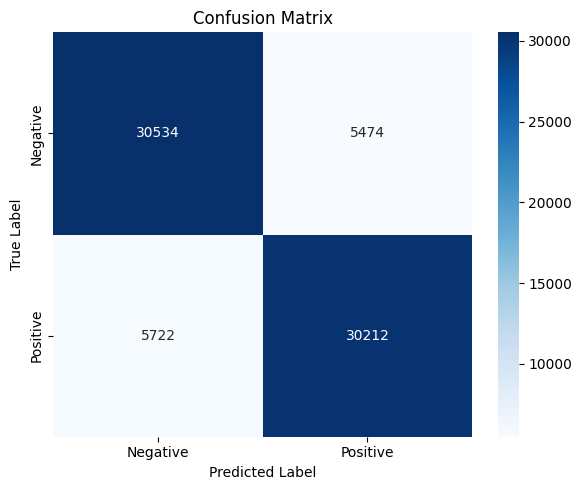

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Positive']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### Predict on a New Review

In [ ]:
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = nb.predict(vectorized)[0]
    return prediction

# Example usage:
review = "This product is a piece of beautiful pretty "
result = predict_sentiment(review)
print(f"Predicted Sentiment: {'Positive' if result == 1 else 'Negative'}")

Predicted Sentiment: Positive


## Tf-idf and LogisticRegression

In [26]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model        import LogisticRegression
from sklearn.metrics             import accuracy_score, f1_score

# 1) Your hyper‐parameters
params = {
    "vectorizer":   "CountVectorizer",
    "max_features": 5000,
    "model_type":   "LogisticRegression",
    "C":            1.0,
    "penalty":      "l2"
}

# 2) Point at your experiment (created if needed)
mlflow.set_experiment("text_classification_experiment")

with mlflow.start_run():
    # 3a) Log the parameters
    mlflow.log_params(params)

    # 3b) Fit your pipeline
    vect  = CountVectorizer(max_features=params["max_features"],
                            stop_words="english")
    X     = vect.fit_transform(df["text"])
    model = LogisticRegression(C=params["C"], penalty=params["penalty"])
    model.fit(X, df["label"])

    # 3c) Evaluate on the same data (or split, if you prefer)
    preds   = model.predict(X)
    acc     = accuracy_score(df["label"], preds)
    f1_w    = f1_score(df["label"], preds, average="weighted")

    # 3d) Log your metrics
    mlflow.log_metric("accuracy",    acc)
    mlflow.log_metric("f1_weighted", f1_w)

    # 3e) Infer a signature and pick a small input example
    signature     = infer_signature(X, preds)
    input_example = df["text"].head(5).tolist()

    # 3f) Log the model *with* signature & example
    mlflow.sklearn.log_model(
        sk_model       = model,
        artifact_path  = "model",
        signature      = signature,
        input_example  = input_example
    )

    # 3g) Log the vectorizer too (one warning is fine)
    mlflow.sklearn.log_model(vect, "vectorizer")

    # 3h) Print them out for immediate feedback
    print("Logged parameters:", params)
    print(f"Logged metrics:   accuracy={acc:.4f}, f1_weighted={f1_w:.4f}")


2025/05/09 19:17:17 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    "stuning even nongamer sound track beautiful paints senery mind well would recomend even people hate vid game music played game chrono cross games ever played best music backs away crude keyboarding takes fresher step grate guitars soulful orchestras would impress anyone cares listen",
    "five star book finished reading whisper wicked saints fell love caracters expected average romance read instead found one favorite books time thought could predict outcome shocked writting descriptive heart broke julias felt instead distant reader lover romance novels must read dont let cover fool book spectacular",
    "fashionable compression stockings dvt doctor required wear compression stockings wore ugly white ted hose yucky thick brown stockings found jobst ultrasheer gave compression needed looked like regular pantyhose even though blood clot gone years still buy wear support stockin

Logged parameters: {'vectorizer': 'CountVectorizer', 'max_features': 5000, 'model_type': 'LogisticRegression', 'C': 1.0, 'penalty': 'l2'}
Logged metrics:   accuracy=0.8827, f1_weighted=0.8826


In [27]:
import os
print("CWD:", os.getcwd())
print("Contents:", os.listdir(os.getcwd()))
print("mlruns exists?:", os.path.isdir("mlruns"))
if os.path.isdir("mlruns"):
    print("Experiments:", os.listdir("mlruns"))


CWD: c:\Users\ramin\Downloads
Contents: ['10.pdf', '14.pdf', '1736882742533.pdf', '2005.11401v4.pdf', '2203.03759.pdf', '2401.06800v1.pdf', '2408.06633v1.pdf', '3uTools_v3.19.021_Setup_x86.exe', '9.pdf', '96eea82d-5559-48c1-9987-26a1e48ebf08.png', 'aachen_000000_000019_gtFinePanopticParts.tif', 'adjusted1_segments.zip', 'adjusted_segments.zip', 'Agritech_Pest_Classification.ipynb', 'Agritech_Pest_EDA_and_Preprocessing.ipynb', 'Agritech_Pest_Prediction(LinearProblem).ipynb', 'Agritech_Pest_Prediction_ARIMAX_TSA.ipynb', 'Agritech_Pest_Prediction_ARIMA_TSA.ipynb', 'Agritech_Pest_Prediction_SARIMAX_TSA.ipynb', 'Agritech_Pest_Prediction_SARIMA_TSA.ipynb', 'ai-system-engineering.ipynb', 'amazonreview.ipynb', 'annotations (1).json', 'annotations (2).json', 'annotations.json', 'app.py', 'asr_correction_predictions (1).xlsx', 'asr_correction_predictions.xlsx', 'asr_correction_synthetic_augmented.tsv', 'asr_correction_synthetic_strong_augmented.tsv', 'Audiosegmentation.ipynb', 'Avvio del procedi

In [32]:
import os
from mlflow.tracking import MlflowClient

# Build and normalize the path to your mlruns folder
mlruns_dir = os.path.abspath("mlruns").replace(os.sep, "/")
tracking_uri = f"file:///{mlruns_dir}"

# Create a client pointed at that URI
client = MlflowClient(tracking_uri=tracking_uri)

# Fetch and print all experiments
print("Listing experiments in:", tracking_uri)
for exp in client.search_experiments():
    print(f" • ID '{exp.experiment_id}' → Name '{exp.name}'")




Listing experiments in: file:///c:/Users/ramin/Downloads/mlruns
 • ID '915400427874617996' → Name 'text_classification_experiment'
 • ID '842929909451602942' → Name 'my_text_classification_experiment'
 • ID '0' → Name 'Default'


### Confusion Matrix

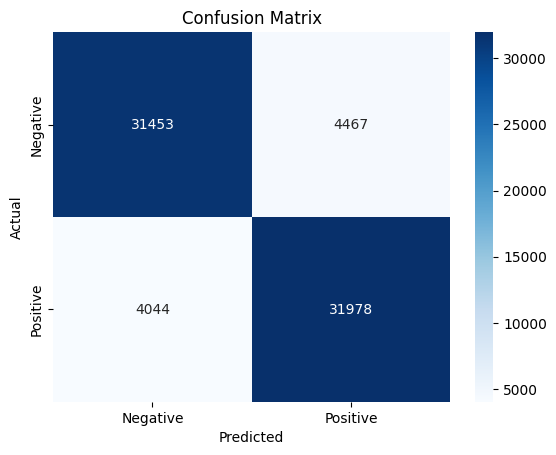

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Check Misclassified Samples

In [21]:
misclassified = df.iloc[y_test.index][y_pred != y_test]
print(misclassified[['text', 'label']].head(10))

                                                     text  label
222423  improbable unlikable inscrutable improbable ev...      1
317866  stang close detail body great paint bad diecas...      2
260792  review maxell wet cleaner cleans exceptionally...      1
150685  grace bland boring least favorite book grace i...      1
276480  want uncut version view region available amazo...      2
75727   bit noisy unit bit noisy much annoying low set...      1
245900  classic dont get book seems meander go crazy t...      1
24830   battery hold charge battery easy find easy pur...      1
20793   nice really play toy exactly plane son wanted ...      1
70589   c allinone really liked book studied using mat...      1


### Predict Sentiment from New Review

In [19]:
def predict_sentiment_lr(review_text):
    # Clean the input
    cleaned = clean_text(review_text)
    
    # Vectorize using the trained TF-IDF vectorizer
    vectorized = vectorizer.transform([cleaned])
    
    # Predict using the trained logistic regression model
    prediction = clf.predict(vectorized)[0]
    
    # Output readable label
    return 'Positive' if prediction == 1 else 'Negative'

# Example usage:
review = "I absolutely love this product. Works perfectly!"
result = predict_sentiment_lr(review)
print(f"Predicted Sentiment: {result}")

Predicted Sentiment: Positive


In [ ]:
import mlflow